# Chapter 9

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [3]:
import numpy as np

import random

import thinkstats2
import thinkplot

## Hypothesis testing

The following is a version of `thinkstats2.HypothesisTest` with just the essential methods:

In [4]:
class HypothesisTest(object):

    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

And here's an example that uses it to compute the p-value of an experiment where we toss a coin 250 times and get 140 heads.

In [5]:
class CoinTest(HypothesisTest):

    def TestStatistic(self, data):
        heads, tails = data
        test_stat = abs(heads - tails)
        return test_stat

    def RunModel(self):
        heads, tails = self.data
        n = heads + tails
        sample = [random.choice('HT') for _ in range(n)]
        hist = thinkstats2.Hist(sample)
        data = hist['H'], hist['T']
        return data

The p-value turns out to be about 7%, which is considered on the border of statistical significance.

In [6]:
ct = CoinTest((140, 110))
pvalue = ct.PValue()
pvalue

0.068

## Permutation test

To compute the p-value of an observed difference in means, we can assume that there is no difference between the groups and generate simulated results by shuffling the data.

In [7]:
class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

Here's an example where we test the observed difference in pregnancy length for first babies and others.

In [8]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [9]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

The p-value is about 17%, which means it is plausible that the observed difference is just the result of random sampling, and might not be generally true in the population.

In [10]:
ht = DiffMeansPermute(data)
pvalue = ht.PValue()
pvalue

0.168

Here's the distrubution of the test statistic (the difference in means) over many simulated samples:

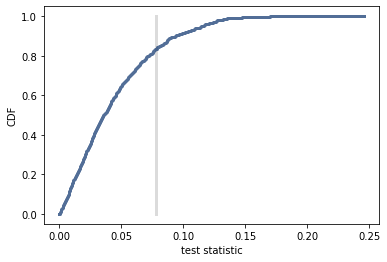

In [11]:
ht.PlotCdf()
thinkplot.Config(xlabel='test statistic',
                   ylabel='CDF')

Under the null hypothesis, we often see differences bigger than the observed difference.

In [12]:
class DiffMeansOneSided(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.mean() - group2.mean()
        return test_stat

If the hypothesis under test is that first babies come late, the appropriate test statistic is the raw difference between first babies and others, rather than the absolute value of the difference.  In that case, the p-value is smaller, because we are testing a more specific hypothesis.

In [13]:
ht = DiffMeansOneSided(data)
pvalue = ht.PValue()
pvalue

0.083

But in this example, the result is still not statistically significant.

## Difference in standard deviation

In this framework, it is easy to use other test statistics.  For example, if we think the variance for first babies might be higher, we can run this test:

In [14]:
class DiffStdPermute(DiffMeansPermute):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = group1.std() - group2.std()
        return test_stat

In [15]:
ht = DiffStdPermute(data)
pvalue = ht.PValue()
pvalue

0.077

But that's not statistically significant either.

## Testing correlation

To check whether an observed correlation is statistically significant, we can run a permutation test with a different test statistic.

In [16]:
class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

Here's an example testing the correlation between birth weight and mother's age.

In [17]:
cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
ht = CorrelationPermute(data)
pvalue = ht.PValue()
pvalue

0.0

The reported p-value is 0, which means that in 1000 trials we didn't see a correlation, under the null hypothesis, that exceeded the observed correlation.  That means that the p-value is probably smaller than $1/1000$, but it is not actually 0.

To get a sense of how unexpected the observed value is under the null hypothesis, we can compare the actual correlation to the largest value we saw in the simulations.

In [18]:
ht.actual, ht.MaxTestStat()

(0.06883397035410904, 0.048747665104395835)

## Testing proportions

Here's an example that tests whether the outcome of a rolling a six-sided die is suspicious, where the test statistic is the total absolute difference between the observed outcomes and the expected long-term averages.

In [19]:
class DiceTest(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum(abs(observed - expected))
        return test_stat

    def RunModel(self):
        n = sum(self.data)
        values = [1, 2, 3, 4, 5, 6]
        rolls = np.random.choice(values, n, replace=True)
        hist = thinkstats2.Hist(rolls)
        freqs = hist.Freqs(values)
        return freqs

Here's an example using the data from the book:

In [20]:
data = [8, 9, 19, 5, 8, 11]
dt = DiceTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.1242

The observed deviance from the expected values is not statistically significant.

By convention, it is more common to test data like this using the chi-squared statistic:

In [21]:
class DiceChiTest(DiceTest):

    def TestStatistic(self, data):
        observed = data
        n = sum(observed)
        expected = np.ones(6) * n / 6
        test_stat = sum((observed - expected)**2 / expected)
        return test_stat

Using this test, we get a smaller p-value:

In [22]:
dt = DiceChiTest(data)
pvalue = dt.PValue(iters=10000)
pvalue

0.042

Taking this result at face value, we might consider the data statistically significant, but considering the results of both tests, I would not draw any strong conclusions.

## Chi-square test of pregnancy length

In [24]:
class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

If we specifically test the deviations of first babies and others from the expected number of births in each week of pregnancy, the results are statistically significant with a very small p-value.  But at this point we have run so many tests, we should not be surprised to find at least one that seems significant.

In [25]:
data = firsts.prglngth.values, others.prglngth.values
ht = PregLengthTest(data)
p_value = ht.PValue()
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

p-value = 0.0
actual = 101.50141482893264
ts max = 29.85063260096127


## Power

Here's the function that estimates the probability of a non-significant p-value even is there really is a difference between the groups.

In [26]:
def FalseNegRate(data, num_runs=1000):
    """Computes the chance of a false negative based on resampling.

    data: pair of sequences
    num_runs: how many experiments to simulate

    returns: float false negative rate
    """
    group1, group2 = data
    count = 0

    for i in range(num_runs):
        sample1 = thinkstats2.Resample(group1)
        sample2 = thinkstats2.Resample(group2)
        ht = DiffMeansPermute((sample1, sample2))
        p_value = ht.PValue(iters=101)
        if p_value > 0.05:
            count += 1

    return count / num_runs

In [27]:
neg_rate = FalseNegRate(data)
neg_rate

0.709

In this example, the false negative rate is 70%, which means that the power of the test (probability of statistical significance if the actual difference is 0.078 weeks) is only 30%.

## Exercises

**Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [32]:
# Pull in the data to use from NSFG
live, firsts, others = first.MakeFrames()

# Set the length of the variable.
lengthLive = len(live)

# Look through the test samples to test the correlations
for _ in range(4):

    # Pull the sample from the rows.
    sample = thinkstats2.SampleRows(live, lengthLive)

    # use the sample to set up the new dataset
    firsts = sample[live.birthord == 1]
    others = sample[live.birthord != 1]

    data = firsts.prglngth.values, others.prglngth.values

    # Add in the hypothesis test and the pvalue
    ht = DiffMeansPermute(data)
    pvalue1 = ht.PValue(iters=1000) # use 1000 iterations

    # Compare the pregnancy lengths 
    pregLengthData = firsts.totalwgt_lb.dropna().values, others.totalwgt_lb.dropna().values
    ht = DiffMeansPermute(pregLengthData)
    pvalue2 = ht.PValue(iters=1000)

    # Test for the correlation between the subsets.
    cleaned = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    cleanedData = cleaned.agepreg.values, cleaned.totalwgt_lb.values
    ht = CorrelationPermute(cleanedData)
    pvalue3 = ht.PValue(iters=1000)

    # Compare the pregnancy lengths using the chi-squared method
    # Use the same data variable that hasn't changed.
    ht = PregLengthTest(data)
    pvalue4 = ht.PValue(iters=1000)

    # Print the results
    count = 1
    print(f'The results for round #{count} of testing are:')
    print(f'P1: {pvalue1}, P2: {pvalue2}, P3: {pvalue3}, P4: {pvalue4}')

    # Divide the results of n to simulate decreasing the size.
    lengthLive //= 2
    count += 1


C:\Users\Josh\AppData\Local\Temp\ipykernel_15068\3737612681.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  firsts = sample[live.birthord == 1]
C:\Users\Josh\AppData\Local\Temp\ipykernel_15068\3737612681.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  others = sample[live.birthord != 1]


The results for round #1 of testing are:
P1: 0.161, P2: 0.0, P3: 0.0, P4: 0.0


C:\Users\Josh\AppData\Local\Temp\ipykernel_15068\3737612681.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  firsts = sample[live.birthord == 1]
C:\Users\Josh\AppData\Local\Temp\ipykernel_15068\3737612681.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  others = sample[live.birthord != 1]


The results for round #1 of testing are:
P1: 0.121, P2: 0.002, P3: 0.0, P4: 0.0


C:\Users\Josh\AppData\Local\Temp\ipykernel_15068\3737612681.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  firsts = sample[live.birthord == 1]
C:\Users\Josh\AppData\Local\Temp\ipykernel_15068\3737612681.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  others = sample[live.birthord != 1]


The results for round #1 of testing are:
P1: 0.853, P2: 0.093, P3: 0.0, P4: 0.002


C:\Users\Josh\AppData\Local\Temp\ipykernel_15068\3737612681.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  firsts = sample[live.birthord == 1]
C:\Users\Josh\AppData\Local\Temp\ipykernel_15068\3737612681.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  others = sample[live.birthord != 1]


The results for round #1 of testing are:
P1: 0.834, P2: 0.047, P3: 0.0, P4: 0.0


In [27]:
# Conclusion...
'''
What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

As the sample size decreases, the p-values increase away from a value that is considered statistically significant (0.05).  However,
for the first tests performed (pvalue1), we can see a much larger change in value as the sample size diminishes which doesn't 
necessarily go up/down consistently.  The smallest sample size that yields a positive test would be the final one used in this test
since the behavior of the values still trends low for values pvalue3 and pvalue4.
'''